In [18]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys 
# sys.path.append("/Users/julianganzabal/facultad/lab-ml/mllab-tools")
from RNN_utils import encode_io_pairs, chars_to_one_hot, sample, window_transform_text
from fnn_helper import PlotLosses

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Formas diferentes de entrenar una RNN con el mismo dataset

## Objetivos:

Comprender los siguientes conceptos:
- Diferencias entre MLP (con features igual a timesteps) y RNN
- Stateful vs stateles en Keras
- Mini-Batch traininig vs SGD training
- Los pesos se actualizan en el backward mientras que el estado de la RNN cambia con cada timestep en el forward
- Padding
- Masking

## Selección de dataset (frase) y preformateo

### Elegimos una frase que tenga una letras repetidas

In [19]:
text="MACHINE LEARNING"

In [20]:
chars = sorted(set(text))
print('Caracteres distintos:')
print(chars)

Caracteres distintos:
[' ', 'A', 'C', 'E', 'G', 'H', 'I', 'L', 'M', 'N', 'R']


In [21]:
window_size=1
chars_to_indices = dict((c, i) for i, c in enumerate(chars))  # map each unique character to unique integer
indices_to_chars = dict((i, c) for i, c in enumerate(chars))

In [22]:
chars_to_indices

{' ': 0,
 'A': 1,
 'C': 2,
 'E': 3,
 'G': 4,
 'H': 5,
 'I': 6,
 'L': 7,
 'M': 8,
 'N': 9,
 'R': 10}

In [23]:
indices_to_chars

{0: ' ',
 1: 'A',
 2: 'C',
 3: 'E',
 4: 'G',
 5: 'H',
 6: 'I',
 7: 'L',
 8: 'M',
 9: 'N',
 10: 'R'}

### Texto a One-hot

In [24]:
one_hot_text = chars_to_one_hot(text, chars, chars_to_indices, window_size)*1
print(one_hot_text)
print(one_hot_text.shape)

[[[0 0 0 0 0 0 0 0 1 0 0]
  [0 1 0 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 1 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 1 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 1 0 0 0 0 0 0]]]
(1, 16, 11)


### One-hot a caracter

In [ ]:
print(indices_to_chars[np.argmax(one_hot_text[0][0])])
print(indices_to_chars[np.argmax(one_hot_text[0][1])])

## Ejemplo 1: T = 1
En este ejemplo usaremos una RNN pero como una simple vanilla network (MLP)

### Preparo entrada/salida:  

In [ ]:
window_transform_text(text, 1, 1)

In [ ]:
window_size = 1
step_size = 1
# encode_io_pairs llama a window_transform_text y despues codifica en one-hot
X, y = encode_io_pairs(text, chars, window_size, step_size)

In [ ]:
print('X:', X.shape, 'y:', y.shape)

In [ ]:
print('N: ', X.shape[0])
print('T: ', X.shape[1])
print('D: ', X.shape[2])

In [ ]:
for xi in X:
    print(xi*1, indices_to_chars[np.argmax(xi)])

In [ ]:
for yi in y:
    print(yi*1, indices_to_chars[np.argmax(yi)])

Notar que la salida es el siguiente caracter al de la entrada

Esto es equivalente a un MLP

### Armo modelo RNN

In [ ]:
from keras.layers import SimpleRNN, Dense
from keras.models import Sequential

In [ ]:
model = Sequential()
model.add(SimpleRNN(10, input_shape=(window_size,len(chars))))
model.add(Dense(len(chars), activation="softmax"))
model.summary()

### Entreno el modelo

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model.fit(X,y, epochs=500, batch_size=1, verbose=1, callbacks=[plot_losses])

Por que no llega al 100%? Que es lo que no puede predecir?

### Predicción usando argmax (Greedy Search)

In [ ]:
char_to_predict = text[0]
to_predict = chars_to_one_hot(char_to_predict, chars, chars_to_indices, window_size)*1
print(char_to_predict, '=', to_predict)
predicted = model.predict(to_predict)
print(predicted)
print(indices_to_chars[np.argmax(predicted)], np.max(predicted))

In [ ]:
chars_to_predict = text[:]
print(chars_to_predict)
# Los paso a one hot
to_predict = chars_to_one_hot(chars_to_predict, chars, chars_to_indices, window_size)*1
print(to_predict)
print(to_predict.shape)

In [ ]:
# Tengo que hacer reshape para darselo a la red
to_predict_reshaped = to_predict.reshape(to_predict.shape[1],to_predict.shape[0],to_predict.shape[2])
print(to_predict_reshaped)
print(to_predict_reshaped.shape)

### Matriz de transición

In [ ]:
predicted = model.predict(to_predict_reshaped)
print(predicted.shape)
print('    ', end='')
for c in chars_to_indices.keys():
    print(c, end='     ')
print()
for i, row in enumerate(predicted):
    print(indices_to_chars[np.argmax(to_predict[:,i])], (row*100).astype(int)/100, indices_to_chars[np.argmax(row)])

Que pasa con la A y la N cuando el texto es MACHINE LEARNING

## Ejemplo 2: T = 2

### Preparo entrada/salida

In [ ]:
window_size = 2
x_2_t, y_2_t = window_transform_text(text, window_size, step_size)
for i, te in enumerate(x_2_t):
    print(te, '->' ,y_2_t[i])
#print(x_2_t, y_2_t)
X_2, y_2 = encode_io_pairs(text, chars, window_size, step_size)

In [ ]:
print(X_2.shape, X_2*1)

In [ ]:
print(y_2*1)

### Armo modelo

In [ ]:
model_2 = Sequential()
model_2.add(SimpleRNN(10, input_shape=(window_size,len(chars))))
model_2.add(Dense(len(chars), activation="softmax"))
model_2.summary()

### Entreno modelo

In [ ]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model_2.fit(X_2,y_2, epochs=500, batch_size=1, verbose=1, callbacks=[plot_losses])

### Matriz de transición

In [ ]:
predicted = model_2.predict(X_2)
print(predicted.shape)
print('     ', end='')
for c in chars_to_indices.keys():
    print(c, end='     ')
print()
for i, row in enumerate(predicted):
    print(indices_to_chars[np.argmax(X_2[i, :][0])]+indices_to_chars[np.argmax(X_2[i, :][1])], (row*100).astype(int)/100, indices_to_chars[np.argmax(row)])

Notar que NI todavía no se puede predecir debido a la ambiguedad

- Como es de esperar la predicción mejora notablemente
- La cantidad de parametros de la red no cambia respecto a la anterior
- Que pasa si lo implemento con MLP con la cantidad de parámetros?

## Ejemplo 3: T = 3

### Preparo entrada/salida

In [ ]:
window_size = 3
x_3_t, y_3_t = window_transform_text(text, window_size, step_size)
for i, te in enumerate(x_3_t):
    print(te, '->' ,y_3_t[i])
#print(x_2_t, y_2_t)
X_3, y_3 = encode_io_pairs(text, chars, window_size, step_size)

### Armo modelo

In [ ]:
model_3 = Sequential()
model_3.add(SimpleRNN(10, input_shape=(window_size,len(chars))))
model_3.add(Dense(len(chars), activation="softmax"))
model_3.summary()

### Entreno modelo

Cambiar batch_size y verificar que converge de la misma manera

In [ ]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model_3.fit(X_3,y_3, epochs=500, batch_size=4, verbose=1, callbacks=[plot_losses])

- Como funciona la RNN con un batch size mayor que 1?
- En que momento se resetea el estado?
- Que dimensión tendrá el vector de estados durante el entrenamiento?

### Matriz de transición

In [ ]:
predicted = model_3.predict(X_3)
print(predicted.shape)
print('     ', end='')
for c in chars_to_indices.keys():
    print(c, end='     ')
print()
for i, row in enumerate(predicted):
    print(indices_to_chars[np.argmax(X_3[i, :][0])]+
          indices_to_chars[np.argmax(X_3[i, :][1])]+
          indices_to_chars[np.argmax(X_3[i, :][2])], 
          (row*100).astype(int)/100, indices_to_chars[np.argmax(row)])

- Las probabilidades son practicamente 1
- La cantidad de parametros de la red no cambia respecto a la anterior
- Que pasa si lo implemento con MLP con la cantidad de parámetros?

### Redefino Modelo con pesos aprendidos pero statefull

In [ ]:
batch_size=1
model_3s = Sequential()
model_3s.add(SimpleRNN(10, batch_input_shape=(batch_size,1,len(chars)), stateful=True))
model_3s.add(Dense(len(chars), activation="softmax"))
model_3s.summary()
model_3s.set_weights(model_3.get_weights())

In [ ]:
window_size=1
model_3s.reset_states()
input_char = text[0]
print('char de entrada:',input_char)
to_predict = chars_to_one_hot(input_char, chars, chars_to_indices, window_size)*1
predicted = model_3s.predict(to_predict)
print('   ', end='')
for c in chars_to_indices.keys():
    print(c, end='     ')
print()
print((predicted*100).astype(int)/100)
print('char predicted:', indices_to_chars[np.argmax(predicted[0])])

Notar que con un solo caracter ingresado, no tiene suficiente data para predecir (Ningun caracter tiene alta probabilidad)

In [ ]:
input_char = text[1]
print('char de entrada:',input_char)
to_predict = chars_to_one_hot(input_char, chars, chars_to_indices, window_size)*1
predicted = model_3s.predict(to_predict)
print('   ', end='')
for c in chars_to_indices.keys():
    print(c, end='     ')
print()
print((predicted*100).astype(int)/100)
print('char predicted:', indices_to_chars[np.argmax(predicted[0])])

la predicción no tiene por que ser correcta a esta altura debido a que el modelo nunca fue entrenado con la secuencia ingresada

In [ ]:
input_char = text[2]
print('char de entrada:',input_char)
to_predict = chars_to_one_hot(input_char, chars, chars_to_indices, window_size)*1
predicted = model_3s.predict(to_predict)
print('   ', end='')
for c in chars_to_indices.keys():
    print(c, end='     ')
print()
print((predicted*100).astype(int)/100)
print('char predicted:', indices_to_chars[np.argmax(predicted[0])])

Notar que luego de la tercer predicción el modelo predice casi perfectamente

In [ ]:
input_char = text[3]
print('char de entrada:',input_char)
to_predict = chars_to_one_hot(input_char, chars, chars_to_indices, window_size)*1
predicted = model_3s.predict(to_predict)
print('   ', end='')
for c in chars_to_indices.keys():
    print(c, end='     ')
print()
print((predicted*100).astype(int)/100)
print('char predicted:', indices_to_chars[np.argmax(predicted[0])])

Notar como suele bajar la probabilidad de la predicción debido a que el modelo no tiene por que predecir secuencias mayores a la longitud entrenada (Aunque en ciertas circunstancias podría generalizar)

In [ ]:
input_char = text[4]
print('char de entrada:',input_char)
to_predict = chars_to_one_hot(input_char, chars, chars_to_indices, window_size)*1
predicted = model_3s.predict(to_predict)
print('   ', end='')
for c in chars_to_indices.keys():
    print(c, end='     ')
print()
print((predicted*100).astype(int)/100)
print('char predicted:', indices_to_chars[np.argmax(predicted[0])])

In [ ]:
input_char = text[5]
print('char de entrada:',input_char)
to_predict = chars_to_one_hot(input_char, chars, chars_to_indices, window_size)*1
predicted = model_3s.predict(to_predict)
print('   ', end='')
for c in chars_to_indices.keys():
    print(c, end='     ')
print()
print((predicted*100).astype(int)/100)
print('char predicted:', indices_to_chars[np.argmax(predicted[0])])

Ya a esta altura estoy tratando de predecir algo probablemente demasiado lejano y no lo puede predecir correctamente

Por eso, si quiero predecir una nueva secuencia de tres, tengo que resetear el estado y luego  mandar de a un caracter

In [ ]:
model_3s.reset_states()
input_char = text[3]
print('char de entrada:',input_char)
to_predict = chars_to_one_hot(input_char, chars, chars_to_indices, window_size)*1
predicted = model_3s.predict(to_predict)
print('   ', end='')
for c in chars_to_indices.keys():
    print(c, end='     ')
print()
print((predicted*100).astype(int)/100)
print('char predicted:', indices_to_chars[np.argmax(predicted[0])])

In [ ]:
input_char = text[4]
print('char de entrada:',input_char)
to_predict = chars_to_one_hot(input_char, chars, chars_to_indices, window_size)*1
predicted = model_3s.predict(to_predict)
print('   ', end='')
for c in chars_to_indices.keys():
    print(c, end='     ')
print()
print((predicted*100).astype(int)/100)
print('char predicted:', indices_to_chars[np.argmax(predicted[0])])

In [ ]:
input_char = text[5]
print('char de entrada:',input_char)
to_predict = chars_to_one_hot(input_char, chars, chars_to_indices, window_size)*1
predicted = model_3s.predict(to_predict)
print('   ', end='')
for c in chars_to_indices.keys():
    print(c, end='     ')
print()
print((predicted*100).astype(int)/100)
print('char predicted:', indices_to_chars[np.argmax(predicted[0])])

Notar que aca tiene una predicción muy alta debido a que esta secuencia fue vista por el modelo

Conclusión importante:  
Si puede usar la statefull para predecir, pero hay que alimentar con el largo orignal de la secuencia para que la salida empiece a tener sentido

## Ejemplo 4: Stateful RNN
Entreno en modo stateful

In [ ]:
window_transform_text(text, 1, 1)

In [ ]:
batch_size=1
model_4 = Sequential()
model_4.add(SimpleRNN(10, batch_input_shape=(batch_size,1,len(chars)), stateful=True))
model_4.add(Dense(len(chars), activation="softmax"))
model_4.summary()

- Notar que X e y son los mismos que en el caso T = 1

In [ ]:
X.shape, y.shape

In [ ]:
batch_size = 1

### Observar: shuffle=False y stateful=True
- Puedo usar otro batch size en este caso?
- Por que suffle tiene que estar en false?

In [ ]:
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
for i in range(300):
    model_4.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model_4.reset_states()

### Voy ingresando de a uno la frase original

In [ ]:
# Probar con 0, 3, 4, 7 y 1
starting = 1
model_4.reset_states()
for c in text[starting:]:
    to_predict = chars_to_one_hot(c, chars, chars_to_indices, window_size)*1
    predicted = model_4.predict(to_predict)
    print(c, '->', indices_to_chars[np.argmax(predicted[0])], int(max(predicted[0])*100)/100)

Con starting en (text es MACHINE LEARNING):
- 0 Predice todo correctamente
- 6 Al arrancar en E puede ser tanto la de L**E**AR.. o la de CHIN**E** .. por lo que no tiene demasiada certeza
- 4 La I da alta probabilidad para la N

### Realimentando salida

In [ ]:
starting = 0
model_4.reset_states()
c = text[starting]
for i in range(25):
    to_predict = chars_to_one_hot(c, chars, chars_to_indices, window_size)*1
    predicted = model_4.predict(to_predict)
    pred_char = indices_to_chars[np.argmax(predicted[0])]
    print(c, '->', pred_char, int(max(predicted[0])*100)/100)
    c = pred_char

## Ejemplo 5: Padding
"The model will learn the zero values carry no information so indeed the sequences are not the same length in terms of content, but same length vectors is required to perform the computation in Keras." https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
https://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/

Como entreno no-statefull pero que de resultados similares a la statefull?

In [ ]:
def window_transform_text_padding_mode(text):
    len_out = len(text)
    
    #output_start[-1] = text[:1]
    #output_start[len_out-1:len_out-2] = text[0:1]
    text = text
    X = []
    y = []
    for i in range(len_out):
        #X.append()
        output_start = ['']*(len_out-1)
        output_start[len_out-i-1:len_out] = text[0:i]
        X.append(output_start)
        y.append(text[i])
    return X, y

### Armo entradas con padding

In [ ]:
X_5, y_5 = window_transform_text_padding_mode(text)

In [ ]:
X_5

In [ ]:
print(y_5)

In [ ]:
chars = sorted(set(text))
chars_to_indices = dict((c, i) for i, c in enumerate(chars))
chars_to_indices[''] = -1

In [ ]:
def code_chars(X, y, chars_to_indices):
    X_coded = []
    y_coded = []
    for i, xi in enumerate(X):
        one_h_y = [0]*(len(chars_to_indices) - 1) # Menos 1 por el '' agregado
        vect = []
        for c in xi:
            one_h = [0]*(len(chars_to_indices) - 1)
            if c == '':
                vect.append(one_h)
            else:
                one_h[chars_to_indices[c]] = 1
                vect.append(one_h)
        X_coded.append(vect)
        one_h_y[chars_to_indices[y[i]]] = 1
        y_coded.append(one_h_y)
    return np.array(X_coded), np.array(y_coded)

In [ ]:
X_coded, y_coded = code_chars(X_5, y_5, chars_to_indices)

In [ ]:
X_coded.shape, y_coded.shape

In [ ]:
# Primer entrada todos ceros
#[['', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
X_coded[0]

In [ ]:
# ['', '', '', '', '', '', '', '', '', '', '', '', '', '', 'M'],
X_coded[1]

### Entreno modelo

In [ ]:
model_5 = Sequential()
model_5.add(SimpleRNN(10, input_shape=(X_coded.shape[1],X_coded.shape[2])))
model_5.add(Dense(len(chars), activation="softmax"))
model_5.summary()

In [ ]:
model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model_5.fit(X_coded,y_coded, epochs=500, batch_size=1, verbose=1, callbacks=[plot_losses])

In [ ]:
to_predict = X_coded
predicted = model_5.predict(to_predict)
for i, row in enumerate(predicted):
    idx = np.argmax(row)
    print(X_5[i], '->', indices_to_chars[idx], int(row[idx]*100)/100)

### Ahora redefino modelo como stateful y cargo los pesos del anterior

In [ ]:
batch_size=1
model_5s = Sequential()
model_5s.add(SimpleRNN(10, batch_input_shape=(batch_size,1,len(chars)), stateful=True))
model_5s.add(Dense(len(chars), activation="softmax"))
model_5s.summary()

In [ ]:
model_5s.set_weights(model_5.get_weights())

### Donde esta el maximo si ingereso ceros?

In [ ]:
model_5s.reset_states()
to_predict = np.zeros((1,1,y_coded.shape[1]))
for i in range(20):
    predicted = model_5s.predict(to_predict)
    idx = np.argmax(predicted[0])
    print(i+1, to_predict, '->', indices_to_chars[idx], int(predicted[0][idx]*100)/100)

In [ ]:
model_5s.reset_states()
to_predict = np.zeros((1,1,y_coded.shape[1]))
for i in range(0):
    predicted = model_5s.predict(to_predict)
    idx = np.argmax(predicted[0])
    print(i+1, to_predict, '->', indices_to_chars[idx], int(predicted[0][idx]*100)/100)

In [ ]:
for i in range(16):
    to_predict = y_coded[i:i+1].reshape(1, 1, len(chars))
    predicted = model_5s.predict(to_predict)
    idx = np.argmax(predicted[0])
    print(to_predict, '->', indices_to_chars[idx], int(predicted[0][idx]*100)/100)

### Realimento salida
Pero no ingreso con one-hot sino con las predicciones

In [ ]:
window_size=1
model_5s.reset_states()
to_predict = np.zeros((1,1,y_coded.shape[1]))
for i in range(2):
    predicted = model_5s.predict(to_predict)
    idx = np.argmax(predicted[0])
    print(i+1, to_predict, '->', indices_to_chars[idx], int(predicted[0][idx]*100)/100)
#print(predicted.shape)
for i in range(16):
    to_predict = predicted.reshape(1, 1, len(chars))
    predicted = model_5s.predict(to_predict)
    idx = np.argmax(predicted[0])
    print((to_predict*100).astype(int)/100, '->', indices_to_chars[idx], int(predicted[0][idx]*100)/100)

## Ejemplo 6: Masking

In [ ]:
from keras.layers import Masking

### Armo modelo

In [ ]:
model_6 = Sequential()
model_6.add(Masking(mask_value=0., input_shape=(X_coded.shape[1],X_coded.shape[2])))
model_6.add(SimpleRNN(10))
model_6.add(Dense(len(chars), activation="softmax"))
model_6.summary()

### Lo entreno

In [ ]:
model_6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model_6.fit(X_coded,y_coded, epochs=1000, batch_size=1, verbose=1, callbacks=[plot_losses])

### Resultados

In [ ]:
to_predict = X_coded
predicted = model_6.predict(to_predict)
for i, row in enumerate(predicted):
    idx = np.argmax(row)
    print(X_5[i], '->', indices_to_chars[idx], int(row[idx]*100)/100)

### Armo modelo stateful y cargo pesos de modelo anterior entrenado

In [ ]:
model_6s = Sequential()
model_6s.add(Masking(mask_value=0., batch_input_shape=(batch_size,1,len(chars))))
model_6s.add(SimpleRNN(10, batch_input_shape=(batch_size,1,len(chars)), stateful=True))
model_6s.add(Dense(len(chars), activation="softmax"))
model_6s.summary()

In [ ]:
model_6s.set_weights(model_6.get_weights())

In [ ]:
# Comentar el reset_states y ver que pasa
# Entrenar 2 de 500 epochs

model_6s.reset_states()

for i in range(16):
    to_predict = y_coded[i:i+1].reshape(1, 1, len(chars))
    predicted = model_6s.predict(to_predict)
    idx = np.argmax(predicted[0])
    print(str(to_predict)+' '+text[i], '->', indices_to_chars[idx], int(predicted[0][idx]*100)/100)

### Arrancando del medio

In [ ]:
model_6s.reset_states()
st = 8
for i in range(5):
    to_predict = y_coded[i+st:i+st+1].reshape(1, 1, len(chars))
    predicted = model_6s.predict(to_predict)
    idx = np.argmax(predicted[0])
    print(str(to_predict)+' '+text[i+st], '->', indices_to_chars[idx], int(predicted[0][idx]*100)/100)


### Ventajas/Desventajas entre este método y stateful
- Ventajas: Este metodo permite el entrenamiento de a batches de manera mas simple
- Desventajas: Se la secuencia es muy larga el unfolding termina siendo demasiado largo y requiere mas memoria y procesamiento

Nota: En stateful, dependiendo del problema, se puede entrenar con batch size mayor a uno pero hay que pensar bien el armado de las secuencias de entrenamiento.

Un ejemplo podría ser: Tengo que generar frases cortas de longitud variable y quiero que aprenda un modelo de lenguage para generar una frase corta

## Ejemplo 7: Return sequence

In [25]:
text="#MACHINE LEARNING$"
chars = sorted(set(text))
print('Caracteres distintos:')
print(chars)
window_size=1
chars_to_indices = dict((c, i) for i, c in enumerate(chars))  # map each unique character to unique integer
indices_to_chars = dict((i, c) for i, c in enumerate(chars))
one_hot_text = chars_to_one_hot(text, chars, chars_to_indices, window_size)*1
print(one_hot_text)
print(one_hot_text.shape)

Caracteres distintos:
[' ', '#', '$', 'A', 'C', 'E', 'G', 'H', 'I', 'L', 'M', 'N', 'R']
[[[0 1 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0 0]
  [0 0 0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 1 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0 0 0]]]
(1, 18, 13)


In [39]:
X_train = one_hot_text[:, :-1, :]
y_train = one_hot_text[:, 1:, :]

In [40]:
X_train.shape, y_train.shape

((1, 17, 13), (1, 17, 13))

In [56]:
from keras.layers import SimpleRNN, Dense
from keras.models import Sequential
model_7 = Sequential()
model_7.add(LSTM(10, return_sequences=True, input_shape=(X_train.shape[1],len(chars))))
model_7.add(Dense(len(chars), activation="softmax"))
model_7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, 17, 10)            240       
_________________________________________________________________
dense_8 (Dense)              (None, 17, 13)            143       
Total params: 383
Trainable params: 383
Non-trainable params: 0
_________________________________________________________________


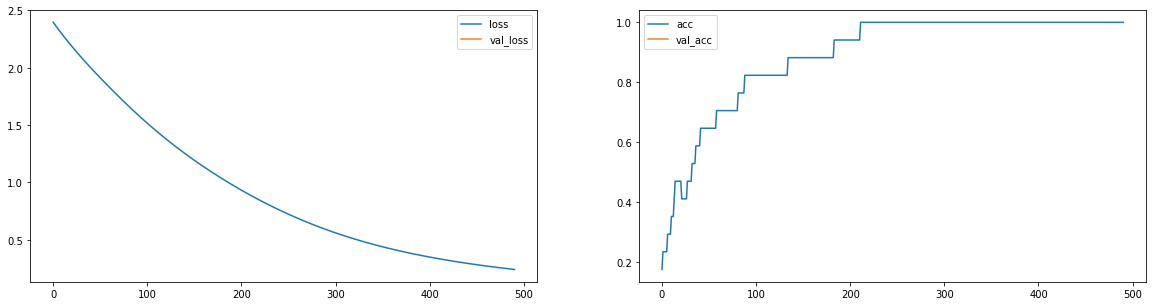

1/1 [==============================] - 0s 349ms/step - loss: 0.2428 - acc: 1.0000
Epoch 492/500
1/1 [==============================] - 0s 13ms/step - loss: 0.2419 - acc: 1.0000
Epoch 493/500
1/1 [==============================] - 0s 14ms/step - loss: 0.2410 - acc: 1.0000
Epoch 494/500
1/1 [==============================] - 0s 12ms/step - loss: 0.2401 - acc: 1.0000
Epoch 495/500
1/1 [==============================] - 0s 11ms/step - loss: 0.2392 - acc: 1.0000
Epoch 496/500
1/1 [==============================] - 0s 13ms/step - loss: 0.2383 - acc: 1.0000
Epoch 497/500
1/1 [==============================] - 0s 11ms/step - loss: 0.2374 - acc: 1.0000
Epoch 498/500
1/1 [==============================] - 0s 10ms/step - loss: 0.2365 - acc: 1.0000
Epoch 499/500
1/1 [==============================] - 0s 13ms/step - loss: 0.2356 - acc: 1.0000
Epoch 500/500
1/1 [==============================] - 0s 12ms/step - loss: 0.2347 - acc: 1.0000


In [42]:
model_7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model_7.fit(X_train,y_train, epochs=500, batch_size=1, verbose=1, callbacks=[plot_losses])

In [50]:
X_train.shape

(1, 17, 13)

In [61]:
model_7.predict(X_train).shape

(1, 17, 13)

In [52]:
model_7.predict_classes(X_train)

array([[10,  3,  4,  7,  8, 11,  5,  0,  9,  5,  3, 12, 11,  8, 11,  6,  2]])

In [53]:
indices_to_chars

{0: ' ',
 1: '#',
 2: '$',
 3: 'A',
 4: 'C',
 5: 'E',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'L',
 10: 'M',
 11: 'N',
 12: 'R'}

# Encoder decoder
https://machinelearningmastery.com/encoder-decoder-long-short-term-memory-networks/

# Sentiment analysis con CNN y LSTM
https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

# Word-level language model

https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/

# return_sequence vs return_state
https://www.quora.com/What-is-the-difference-between-states-and-outputs-in-LSTM

https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/

# Truncated BPTT 
https://machinelearningmastery.com/truncated-backpropagation-through-time-in-keras/